# Modeling - Proyek Analisis Sentimen

## Import library

In [1]:
!pip install google-play-scraper

from google_play_scraper import app, reviews, Sort

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import csv
import requests
from io import StringIO

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading Dataset

In [2]:
data_review = pd.read_csv('ulasan_tokopedia.csv')

In [3]:
data_review.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,91175a1f-cb81-4180-943f-38925de4b3a8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,CS BALES LAMA DAN SEMUA KERJANYA LELET MAU REF...,1,0,3.305.0,2025-04-13 16:53:15,"Hi Toppers, silakan sampaikan kritik/saran ata...",2025-04-13 17:27:03,3.305.0
1,b58fad6a-27bd-4d8e-a99b-a60bb8f4dbd5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Pemula menggunakan Aplikasi ini,4,0,NaN,2025-04-13 16:17:37,"Toppers, terima kasih atas rating yang kamu be...",2025-04-13 16:47:23,NaN
2,0b38f5c9-475f-4c27-a67a-2286fa266308,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,tolong untuk seller penjual barang palsu yang ...,4,0,3.305.0,2025-04-13 16:10:02,Terima kasih sudah mempercayakan Tokopedia seb...,2025-04-13 16:47:24,3.305.0
3,857d4e1b-1934-4988-ab02-9b7844ca60e9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ok,5,0,3.305.0,2025-04-13 15:32:45,Terima kasih sudah mempercayakan Tokopedia seb...,2025-04-13 16:07:02,3.305.0
4,97f37c24-4ccc-4ba7-8104-1ec3f706fe00,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,pesanan dibatalkan sistem tapi saldo bonus tid...,1,0,3.305.0,2025-04-13 15:26:54,"Halo Toppers, terima kasih atas rating yang ka...",2025-04-13 15:47:02,3.305.0


Dari hasil scraping, diperoleh dataset dengan 15.000 baris dan 11 kolom. Kemudian terdapat beberapa kolom yang memiliki missing values.

In [4]:
data_review.shape

(15000, 11)

In [5]:
data_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15000 non-null  object
 1   userName              15000 non-null  object
 2   userImage             15000 non-null  object
 3   content               14999 non-null  object
 4   score                 15000 non-null  int64 
 5   thumbsUpCount         15000 non-null  int64 
 6   reviewCreatedVersion  11784 non-null  object
 7   at                    15000 non-null  object
 8   replyContent          14997 non-null  object
 9   repliedAt             14997 non-null  object
 10  appVersion            11784 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Dilakukan drop pada data yang terduplikat dan memiliki missing values. Diperoleh jumlah data sebanyak 11.780 yang selanjutnya dapat digunakan untuk analisis klasifikasi.

In [6]:
data_review.dropna(inplace=True)
data_review.drop_duplicates(inplace=True)

In [7]:
data_review.shape

(11780, 11)

In [8]:
data_review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11780 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              11780 non-null  object
 1   userName              11780 non-null  object
 2   userImage             11780 non-null  object
 3   content               11780 non-null  object
 4   score                 11780 non-null  int64 
 5   thumbsUpCount         11780 non-null  int64 
 6   reviewCreatedVersion  11780 non-null  object
 7   at                    11780 non-null  object
 8   replyContent          11780 non-null  object
 9   repliedAt             11780 non-null  object
 10  appVersion            11780 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB


Untuk permodelan, hanya akan digunakan data pada kolom 'content'.

In [9]:
df = data_review[['content']].copy()

In [10]:
df.head()

,content
0,CS BALES LAMA DAN SEMUA KERJANYA LELET MAU REF...
2,tolong untuk seller penjual barang palsu yang ...
3,ok
4,pesanan dibatalkan sistem tapi saldo bonus tid...
6,coba daftar affiliate tapi internal server err...


## Pre-Processing

Pre-Prcessing dilakukan dengan membersihkan teks, mengonversi karakter, memecah teks, menghapus stopwords, menerapkan stemming dan menggabungkan kata-kata menjadi kalimat.Dilakukan juga penghapusan slang words.

In [11]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

def casefoldingText(text):
    return text.lower()

slangwords = {"abis": "habis", "bgt": "banget", "ga": "tidak", "gk": "tidak", "gpp": "tidak apa apa", "gak": "tidak", "tdk": "tidak", "yg": "yang", "bagu" : "bagus"}
def fix_slangwords(text):
    return ' '.join([slangwords.get(word, word) for word in text.split()])

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(tokens):
    stop_words = set(stopwords.words('indonesian'))
    return [w for w in tokens if w not in stop_words]

def toSentence(tokens):
    return ' '.join(tokens)

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmingText(text):
    return stemmer.stem(text)

Penerapan pre-processing :

In [12]:
df['text_clean'] = df['content'].apply(cleaningText)
df['text_casefold'] = df['text_clean'].apply(casefoldingText)
df['text_slangwords'] = df['text_casefold'].apply(fix_slangwords)
df['text_stemmed'] = df['text_slangwords'].apply(stemmingText)

In [13]:
def tokenizingText(text):
    return text.split()

df['text_tokenized'] = df['text_stemmed'].apply(tokenizingText)
df['text_stopword'] = df['text_tokenized'].apply(filteringText)
df['text_final'] = df['text_stopword'].apply(toSentence)

## Pelabelan

Data akan dibagi menjadi tiga jenis label yaitu 'positive', 'neutral', dan 'negative'. Dilakukan analisis sentimen pada teks berbahasa Indonesia dengan menggunakan kamus kata-kata positif dan negatif yang diperoleh dari GitHub. Kemudian diperoleh skor sentimen yang akan digunakan untuk menentukan polaritas teks apakah positive, neutral atau negative.

In [14]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
  reader = csv.reader(StringIO(response.text), delimiter=',')

  for row in reader:
    lexicon_positive[row[0]] = int(row[1])

else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
      lexicon_negative[row[0]] = int(row[1])

else:
    print("Failed to fetch negative lexicon data")

In [15]:
# Fungsi untuk menentukan polaritas sentimen dari tweet
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
      if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:
      if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity=''

    if (score > 0):
        polarity = 'positive'
    elif (score == 0):
        polarity = 'neutral'
    else:
      polarity = 'negative'

    return score, polarity

In [16]:
results = df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

polarity
positive    5457
negative    4289
neutral     2034
Name: count, dtype: int64


## Eksplorasi Label

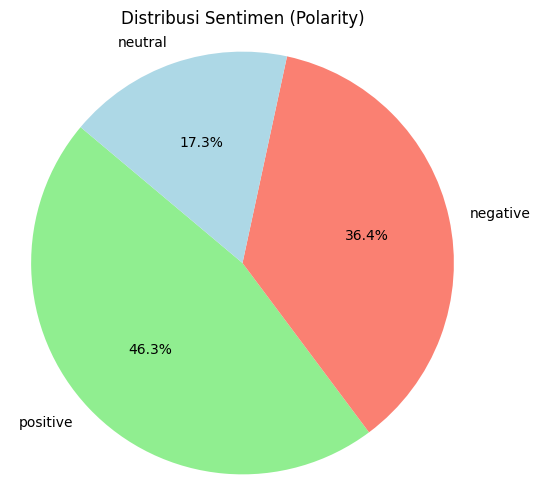

In [17]:
polarity_counts = df['polarity'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', colors=['lightgreen', 'salmon', 'lightblue'], startangle=140)
plt.title('Distribusi Sentimen (Polarity)')
plt.axis('equal')
plt.show()

Diperoleh hasil, terdapat 5457 teks (46.4%) dengan polaritas positive, 4289 teks (36.4%) dengan polaritas negative dan 2034 teks (17.3%) dengan polaritas neutral.

In [18]:
def get_text_by_label(df, label=None):
    if label:
        text_data = df[df['polarity'] == label]['text_final']
    else:
        text_data = df['text_final']
    return ' '.join(text_data)

text_all = get_text_by_label(df)
text_positive = get_text_by_label(df, 'positive')
text_negative = get_text_by_label(df, 'negative')
text_neutral  = get_text_by_label(df, 'neutral')

wordcloud_all = WordCloud(width=800, height=600, background_color='white', colormap='viridis').generate(text_all)
wordcloud_pos = WordCloud(width=800, height=600, background_color='white', colormap='Greens').generate(text_positive)
wordcloud_neg = WordCloud(width=800, height=600, background_color='white', colormap='Reds').generate(text_negative)
wordcloud_neu = WordCloud(width=800, height=600, background_color='white', colormap='Blues').generate(text_neutral)

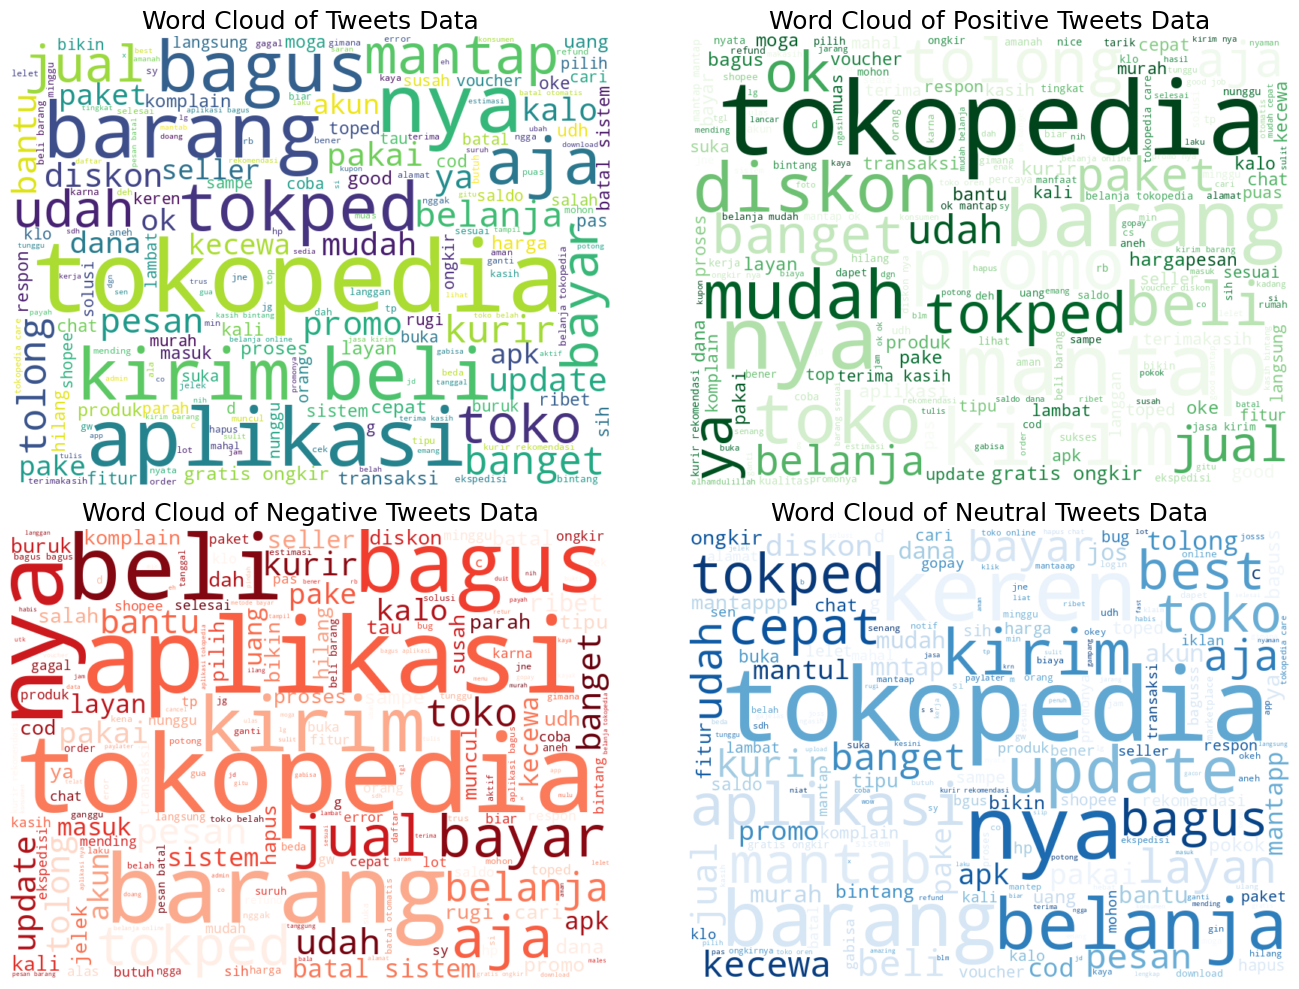

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tweets Data", fontsize=18, color='black')

# Positive
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Positive Tweets Data", fontsize=18, color='black')

# Negative
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Negative Tweets Data", fontsize=18, color='black')

# Neutral
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Neutral Tweets Data", fontsize=18, color='black')

plt.tight_layout()
plt.show()


Penyebaran kata pada setiap label terdapat pada visualisasi di atas. Berdasarkan visualisasi word cloud, kata "tokopedia", "barang", dan "aplikasi" mendominasi di keempat kategori sentimen, menandakan topik yang paling sering dibahas pengguna. Pada ulasan positif, muncul kata-kata seperti "mudah", "diskon", dan "paket", menunjukkan kepuasan terhadap kemudahan penggunaan dan promo. Di sisi lain, ulasan negatif menonjolkan kata seperti "bayar", "kurir", dan "komplain", yang mengindikasikan masalah utama terkait pembayaran dan pengiriman. Ulasan netral dan umum memperlihatkan kosakata yang lebih beragam namun cenderung informatif, tanpa muatan emosional yang kuat.

## Data Splitting dan Ekstraksi Fitur dengan TF-IDF

Dilakukan ekstraksi fitur dengan menggunakan metode TF-IDF. Selanjutnya, ata dibagi menjadi data latih dan data uji menggunakan train_test_split dengan proporsi data latih sebesar 80% serta data uji sebesar 20%.

In [20]:
X = df['text_final']
y = df['polarity']

tfidf = TfidfVectorizer(max_features=5000, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

## Modeling

Pada modeling klasifikasi digunakan algoritma Random Forest, Logistic Regression dan SVC.

### Random Forest

In [23]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train.toarray(), y_train)

y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9882215619694398
Random Forest - accuracy_test: 0.8569609507640068


### Logistic Regression

In [24]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train.toarray(), y_train)

y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.9138370118845501
Logistic Regression - accuracy_test: 0.8875212224108658


### SVM

In [25]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train.toarray(), y_train)

y_pred_train_svm = svm_model.predict(X_train.toarray())
y_pred_test_svm = svm_model.predict(X_test.toarray())

accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)


SVM - accuracy_train: 0.9198853989813243
SVM - accuracy_test: 0.8887945670628183


Berdasarkan hasil evaluasi model, ketiga algoritma yaitu Random Forest, Logistic Regression, dan SVM menunjukkan performa yang baik dalam mengklasifikasikan sentimen, dengan akurasi uji di atas 85%. SVM menghasilkan akurasi uji tertinggi sebesar 88.88%, sedikit lebih besar Logistic Regression (88.75%) dan Random Forest (85.69%). Secara keseluruhan, SVM menjadi model yang paling seimbang dan direkomendasikan untuk digunakan dalam analisis sentimen ini.